In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


Pole pozycji to powtarzające się pole rekordów. Różni się to od event_params i user_properties, które zamiast tego powtarzają podstawowe typy wartości (string, integer, float).

Pole elementów może być uwzględnione w prawie każdym zdarzeniu e-commerce, ale jest tym bardziej znaczące, im dalej jesteś na ścieżce. Tak więc zakupy (zazwyczaj) mówią więcej o sukcesie Twoich produktów niż wyświetlenia szczegółów produktu lub dodawanie zdarzeń do koszyka.

Twórz wskaźniki, takie jak współczynnik obejrzeń do zakupu (jaki jest stosunek zakupów produktu do łącznej liczby wyświetleń produktu), aby lepiej zrozumieć, jak Twoje produkty przechodzą przez ścieżkę e-commerce.

Explore Items Data

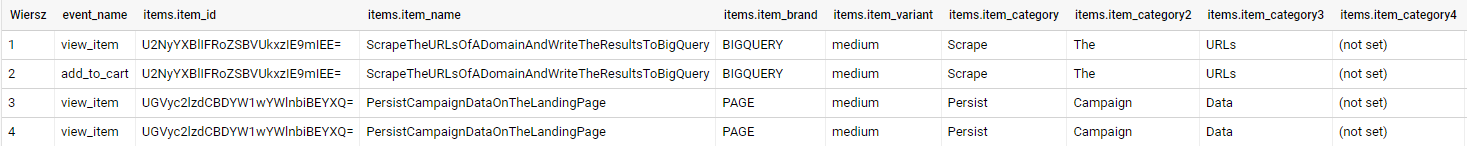

In [ ]:
%%bigquery --project 

select 
    event_name,
    items
from 
    `ga.events_20210701`,
    unnest(items)
LIMIT 4

,event_name,items
0,view_item,"[{'item_id': 'U2NyYXBlIFRoZSBVUkxzIE9mIEE=', '..."
1,add_to_cart,"[{'item_id': 'U2NyYXBlIFRoZSBVUkxzIE9mIEE=', '..."
2,view_item,"[{'item_id': 'UGVyc2lzdCBDYW1wYWlnbiBEYXQ=', '..."
3,view_item,"[{'item_id': 'UGVyc2lzdCBDYW1wYWlnbiBEYXQ=', '..."


Count Items And Revenue

In [ ]:
%%bigquery --project 

select 
    sum(items.quantity) as items,
    sum(items.item_revenue) as item_revenue
from 
    `ga.events_20210701`,
    unnest(items) as items
where 
    event_name = 'purchase'

,items,item_revenue
0,2104,136718.0


Build An Items Funnel With Events

In [ ]:
%%bigquery --project produkcja-instore

with prep as (
select 
    event_name,
    items.item_name,
    sum(items.quantity) as items
from 
    `ga.events_20210701`,
    unnest(items) as items
group by 
    event_name,
    item_name)

select 
    item_name,
    sum(case when event_name = 'view_item' then items else 0 end) as view_item,
    sum(case when event_name = 'add_to_cart' then items else 0 end) as add_to_cart,
    sum(case when event_name = 'begin_checkout' then items else 0 end) as begin_checkout,
    sum(case when event_name = 'purchase' then items else 0 end) as purchase,
    safe_divide(sum(case when event_name = 'purchase' then items else 0 end),sum(case when event_name = 'view_item' then items else 0 end)) as view_to_purchase_rate
from 
    prep
group by 
    item_name
order by 
    view_item desc